In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

import xgboost as xgb
import shap
import matplotlib.pyplot as plt
%matplotlib inline

shap.initjs()

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Data Preprocessing

In [23]:
# load dataset
df = pd.read_csv('car.csv')
print(df.shape)
df.rename(columns={"Saftety":"Safety"},inplace=True)
df.head()

(1728, 7)


,Bying,Maint,Doors,Persons,Lug_Boot,Safety,Class_Val
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


In [24]:
feature_loc = ['Bying', 'Maint', 'Doors', 'Persons', 'Lug_Boot', 'Safety']
X = df.loc[:, feature_loc]
Y = df.Class_Val

print(X.shape, Y.shape)

(1728, 6) (1728,)


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=.2, random_state=0)
d_train = xgb.DMatrix(X_train, label=Y_train)
d_test = xgb.DMatrix(X_test, label=Y_test)

### Model selected by TPOT

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=0.6500000000000001, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=14,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None,
              subsample=0.9500000000000001, verbose=0, warm_start=False)

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [28]:
model =  XGBClassifier (
    learning_rate=1.0,
    max_depth=3,
    objective="multi:softmax",
    subsample= 0.95,
    base_score=np.mean(Y_train),
    n_estimator=100,
    max_features=0.65,
    min_samples_leaf=20,
    min_samples_split=14 
)
model.fit(X_train, Y_train, eval_metric='mlogloss', verbose=True,
            eval_set=[(X_test, Y_test)], early_stopping_rounds=20)

[0]	validation_0-mlogloss:0.586551
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:0.416186
[2]	validation_0-mlogloss:0.331614
[3]	validation_0-mlogloss:0.265621
[4]	validation_0-mlogloss:0.23267
[5]	validation_0-mlogloss:0.198237
[6]	validation_0-mlogloss:0.176024
[7]	validation_0-mlogloss:0.154204
[8]	validation_0-mlogloss:0.132377
[9]	validation_0-mlogloss:0.125431
[10]	validation_0-mlogloss:0.114767
[11]	validation_0-mlogloss:0.109343
[12]	validation_0-mlogloss:0.104242
[13]	validation_0-mlogloss:0.101569
[14]	validation_0-mlogloss:0.094612
[15]	validation_0-mlogloss:0.087481
[16]	validation_0-mlogloss:0.083613
[17]	validation_0-mlogloss:0.074492
[18]	validation_0-mlogloss:0.074119
[19]	validation_0-mlogloss:0.071601
[20]	validation_0-mlogloss:0.06563
[21]	validation_0-mlogloss:0.059359
[22]	validation_0-mlogloss:0.059073
[23]	validation_0-mlogloss:0.054702
[24]	validation_0-mlogloss:0.05203
[25]	validation_0-mlogloss:0.051161
[26]	val

XGBClassifier(base_score=1.4153400868306802, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=1.0,
       max_delta_step=0, max_depth=3, max_features=0.65,
       min_child_weight=1, min_samples_leaf=20, min_samples_split=14,
       missing=None, n_estimator=100, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.95)

In [29]:
y_pre = model.predict(X_test)
print("Testing Accuracy : %.4g%%" % (accuracy_score(Y_test, y_pre)*100))

Testing Accuracy : 98.27%


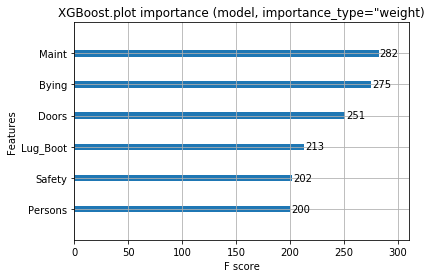

In [30]:
xgb.plot_importance(model,importance_type="weight")
plt.title('XGBoost.plot importance (model, importance_type="weight)')
plt.show()

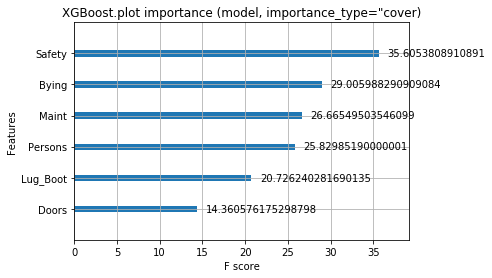

In [31]:
xgb.plot_importance(model,importance_type="cover")
plt.title('XGBoost.plot importance (model, importance_type="cover)')
plt.show()

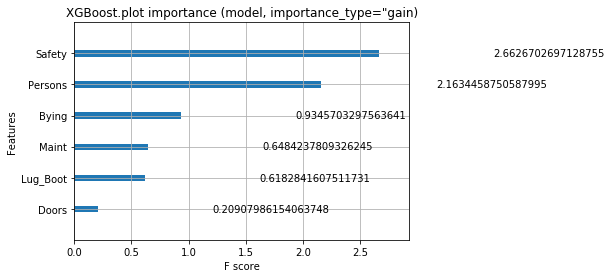

In [32]:
xgb.plot_importance(model,importance_type="gain")
plt.title('XGBoost.plot importance (model, importance_type="gain)')
plt.show()

In [113]:
shap_values = shap.TreeExplainer(model).shap_values(X)
shap_values = np.asarray(shap_values)
shap.force_plot(shap_values[0][0,:], X.iloc[0,:],link='logit')

In [128]:
shap_values = shap_values[0,:,:]
shap_values.shape

(1728, 7)

In [138]:
shap.force_plot(shap_values,X,link='logit')

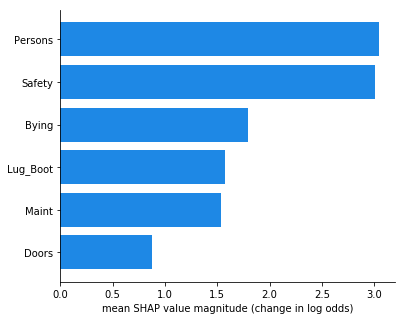

In [131]:
globat_shap_vals = np.abs(shap_values).mean(0)[:-1]
inds = np.argsort(globat_shap_vals)
y_pos = np.arange(X.shape[1])
plt.barh(y_pos, globat_shap_vals[inds], color='#1E88E5')
plt.yticks(y_pos, X.columns[inds])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(6,5)
plt.show()

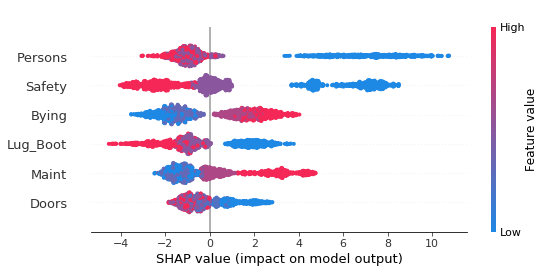

In [132]:
shap.summary_plot(shap_values, X)

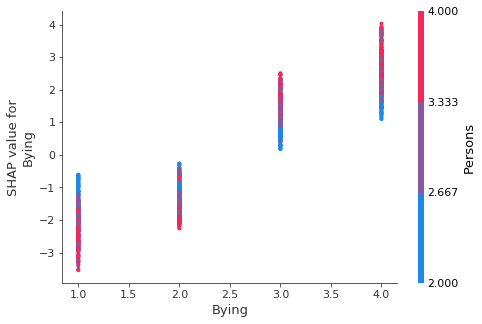

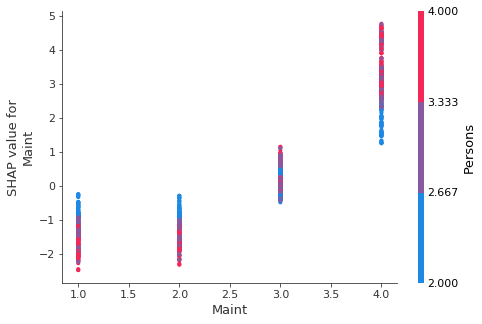

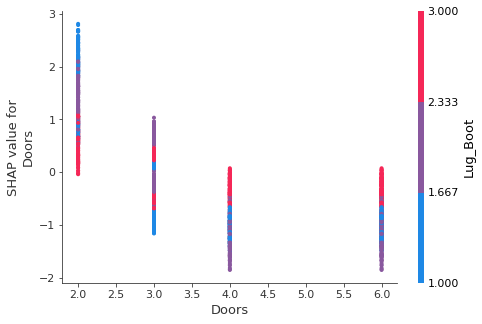

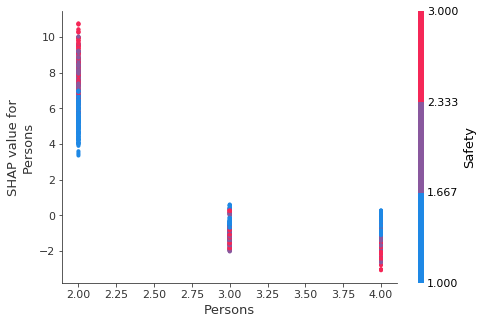

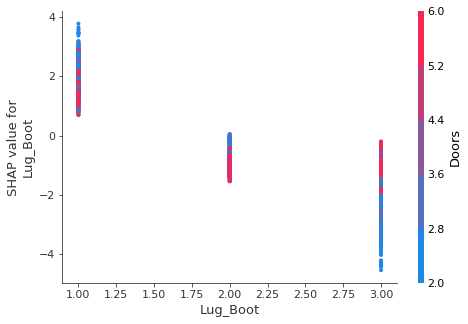

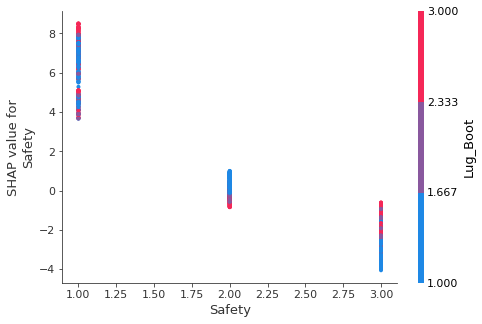

In [133]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X)